## 1.2.1 Ideal single camera calibration using DLT w norm multiple points

**In this script, we intend to obtain an ideal calibration( meaning 0 error) with DLT with normalization.**\
 In order to achieve that it is important to know the calibration matrix in advance. Otherwise, if we generate world points and image points at random with the purpose of finding the projection matrix, the points generate might not have real use correspondence.


When dealing with an uncalibrated camera, 11 parameters are unknown, meaning we need at least **6 points** and assume the model of the camera is **affine**.
>**Problem specification:**
- Estimate the 11 elements of P given:
    - 3D coordinates $X_{i}$ of I $\geq$ 6 object points


<img src="/home/alegria/calibration/images/camera_orientation.png" width=400 height=400 />


**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
DECIMALS = 2  # how many decimal places to use in print


### Set of Functions

In [2]:
def to_inhomogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("x must be one-dimensional.")

    return (X / X[-1])[:-1]


def to_homogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("X must be one-dimensional.")

    return np.hstack([X, 1])

def to_homogeneous_arr(X: np.ndarray) -> np.ndarray:
    one_matrix = np.ones((X.shape[0],1))

    out_value = np.concatenate((X, one_matrix), axis=1)

    return out_value

def _get_roll_matrix(theta_x: float = 0.0) -> np.ndarray:
    Rx = np.array(
        [
            [1.0, 0.0, 0.0],
            [0.0, np.cos(theta_x), -np.sin(theta_x)],
            [0.0, np.sin(theta_x), np.cos(theta_x)],
        ]
    )
    return Rx


def _get_pitch_matrix(theta_y: float = 0.0) -> np.ndarray:
    Ry = np.array(
        [
            [np.cos(theta_y), 0.0, np.sin(theta_y)],
            [0.0, 1.0, 0.0],
            [-np.sin(theta_y), 0.0, np.cos(theta_y)],
        ]
    )
    return Ry


def _get_yaw_matrix(theta_z: float = 0.0) -> np.ndarray:
    Rz = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 0.0],
            [np.sin(theta_z), np.cos(theta_z), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )
    return Rz


#my and mx correspond to the pixel density in the x and y direction
def get_calibration_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = np.diag([mx, my, 1]) @ np.array([[f, 0.0, px], [0.0, f, py], [0.0, 0.0, 1.0]])
    return K

def get_rotation_matrix(
    theta_x: float = 0.0, theta_y: float = 0.0, theta_z: float = 0.0
) -> np.ndarray:
    # Roll
    Rx = _get_roll_matrix(theta_x)
    # Pitch
    Ry = _get_pitch_matrix(theta_y)
    # Yaw
    Rz = _get_yaw_matrix(theta_z)
    return Rz @ Ry @ Rx

def get_translation_matrix(Tx: float,Ty: float,Tz: float):
    return np.array([[Tx],[Ty],[Tz]])

def get_extrinsic_matrix(rot: np.array((3,3)), trans:np.array((3,1))):
    E = np.concatenate((rot,trans), axis = 1)
    return E

def get_projection_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    tx : float = 0.0,
    ty : float = 0.0,
    tz : float = 0.0,
    theta_x: float = 0.0,
    theta_y: float = 0.0,
    theta_z: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = get_calibration_matrix(f=f, px=px, py=py, mx=mx, my=my)
    #print("Calibration matrix: \n",K)
    R = get_rotation_matrix(theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    #print("Rotation matrix: \n",R)
    T = get_translation_matrix(tx,ty,tz)
    #print("Translation matrix: \n",T)
    E = get_extrinsic_matrix(rot = R,trans = T)
    P = K @ E
    
    return P

def get_plucker_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A = to_homogeneous(A)
    B = to_homogeneous(B)
    L = A.reshape(-1, 1) * B.reshape(1, -1) - B.reshape(-1, 1) * A.reshape(1, -1)
    return L



def normalization(data, dim):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Inputs:
    data: the data to be normalized (directions at different columns and points at rows) -> (nº points, nº coordinates)
    Outputs:
    T : the transformation matrix (translation plus scaling)
    '''

    N = data.shape[0]
    
    if dim == 2:                                                     # 2D points
        x, y = data[:, 0], data[:, 1]                               # x and y coordinates
        x_mean, y_mean = x.mean(), y.mean()                         # mean 
        x_par = (x-x_mean)**2                                       # x part
        y_par = (y-y_mean)**2                                       # y part

        d = (1/N)* np.sum(np.sqrt(x_par + y_par))                   # d
        s_xy = np.sqrt(2)/d                                         # sqrt(2)/d

        T = np.zeros((3,3))                                         # normalization matrix for 2D points
        T[0,0] = s_xy
        T[0,2] = -x_mean*s_xy
        T[1,1] = s_xy
        T[1,2] = -y_mean*s_xy
        T[-1,-1] = 1

        coord_n = np.dot(data,np.transpose(T))                          # normalized image coordinates

    elif(dim== 3):                                                  # 3D points
        X, Y, Z = data[:, 0], data[:, 1], data[:,2]                 # x and y coordinates
        X_mean, Y_mean,Z_mean = X.mean(), Y.mean(),Z.mean()         # mean 
        X_par = (X-X_mean)**2                                       # x part
        Y_par = (Y-Y_mean)**2                                       # y part
        Z_par = (Z-Z_mean)**2                                       # z part

        D = (1/N)* np.sum(np.sqrt(X_par + Y_par + Z_par))           # d
        s_xyz = np.sqrt(3)/D                                        # sqrt(2)/d

        T = np.zeros((4,4))                                         # normalization matrix for 3D points
        T[0,0] = s_xyz
        T[0,3] = -X_mean*s_xyz
        T[1,1] = s_xyz
        T[1,3] = -Y_mean*s_xyz
        T[2,2] = s_xyz
        T[2,3] = -Z_mean*s_xyz
        T[-1,-1] = 1

        coord_n = np.dot(data,T.T)                          # normalized world coordinates

    else:
        raise ValueError('Dataset must be a collection of 2D or points')

    return T,coord_n

def denormalization(H_norm,Txy,Txyz):
    H = np.linalg.pinv(Txy).dot((H_norm).dot(Txyz))
    H = H / H[-1, -2]

    return H


In [3]:
def generate_random_points(n_points, xlim, ylim, zlim):
    '''
    Generate random points in the given limits
    '''
    x = np.random.randint(xlim[0], xlim[1], size=n_points)
    y = np.random.randint(ylim[0], ylim[1], size=n_points)
    z = np.random.randint(zlim[0], zlim[1], size=n_points)
    
    return np.vstack((x, y, z))


### Camera parameters

In [4]:
F = 3                                       # focal length( in mm )
sensor_size = np.array([11,7])              # sensor size(mm)
PX= sensor_size[0]/2.0                      # principal point x-coordinate
PY= sensor_size[1]/2.0                      # principal point y-coordinate
IMAGE_HEIGTH = sensor_size[1]
IMAGE_WIDTH = sensor_size[0]
THETA_X = np.pi / 2                         # roll angle
THETA_Z = np.pi                             # yaw angle

C = np.array([6, -5, 2])                    # camera centre


In [5]:
def get_image_points(n_points,px,py,trans_x = 0,trans_y = 0,trans_z = 0,F = 3):

    rand_points = generate_random_points(n_points, (-10, 0), (-10, 10), (F, 10))            # generate random world points 
    K = get_calibration_matrix(F, px=px, py=py)                                             # calibration matrix
    P = get_projection_matrix(F, px=px,py =py,tx = trans_x,ty = trans_y, tz = trans_z)                        # projection matrix

    x = []

    for i in range(n_points):
        Xh = to_homogeneous(rand_points[:,i])
        xh = P @ Xh
        Xx = to_inhomogeneous(xh)
        x.append(Xx)

    x_arr = np.array(x)

    return x_arr, rand_points.T

In [6]:
def SVD(M):
    U, S, Vh = np.linalg.svd(M)

    L = Vh[-1,:] / Vh[-1,-2]
    #Camera projection matrix:
    PEst = L.reshape(3,3+1)
    #print("Camera Matrix:\n",PEst)

    return PEst

In [7]:
def DLT(x_arr,X_arr):

    worldm, worldn = X_arr.shape
    imagem, imagen = x_arr.shape
    
    #3D DLT
    A = []
    world_pts = X_arr
    image_pts = x_arr

    for i in range(worldm):
        A.append([-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,0,0,0,0,image_pts[i,0]*world_pts[i,0],image_pts[i,0]*world_pts[i,1],image_pts[i,0]*world_pts[i,2],image_pts[i,0]])
        A.append([0,0,0,0,-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,image_pts[i,1]*world_pts[i,0],image_pts[i,1]*world_pts[i,1],image_pts[i,1]*world_pts[i,2],image_pts[i,1]])

    # pass the list A as an array
    M = np.asarray(A).reshape(worldm*2,12)
    #print(M.shape)
    
    PEst = SVD(M)
    return PEst

### Projection matrix estimation

## For multiple n points
Testing the geometric error for n points:
- 10
- 100
- 1000
- 10000

In [15]:
n_pts = ([2,5,10,100,1000,5000,10000])

err_list = []

for pts in n_pts: 
    # empty the projection matrix
    PEst = np.empty((3,4))
    x_arr = 0
    
    x_arr, X_arr = get_image_points(pts,PX,PY)
    #print(X_arr)
    #print(x_arr)
    X_h = to_homogeneous_arr(X_arr)
    x_h = to_homogeneous_arr(x_arr)

    Txyz, X_h_n = normalization(X_h, 3)
    Txy, x_h_n = normalization(x_h, 2)

    P_n = DLT(x_h_n,X_h_n)

    PEst = denormalization(P_n,Txy,Txyz)

    print("Camera Matrix:\n",PEst)

    n_points = X_h_n.shape[0]
    xEst = np.zeros((n_points,2))

    for j in range(n_points):
        X_pts = to_homogeneous(X_arr[j])
        x_aux  = np.dot(PEst,X_pts)
        xEst[j,:] = to_inhomogeneous(x_aux)
        
    err_list.append(np.mean(np.sum(np.square(x_arr-xEst), 1)))



Camera Matrix:
 [[ 25.88916204   2.99507614  53.81199478 -15.21411665]
 [  5.43188543  38.02319799  16.29565628 229.73852328]
 [  0.33333333   2.33333333   1.          83.89533969]]
Camera Matrix:
 [[ 2.95415452  0.20974112  5.49514636  1.48020553]
 [-0.33460205  3.52643474  3.15999904  4.11276845]
 [-0.02449834  0.07470767  1.          0.43433479]]
Camera Matrix:
 [[ 3.00000000e+00 -1.61823827e-15  5.50000000e+00  2.92839145e-14]
 [ 1.10754702e-15  3.00000000e+00  3.50000000e+00  1.95227218e-14]
 [-1.27616338e-16 -3.14539800e-16  1.00000000e+00  6.31510125e-15]]
Camera Matrix:
 [[ 3.00000000e+00 -6.86760483e-16  5.50000000e+00  3.63018740e-14]
 [-4.96084368e-17  3.00000000e+00  3.50000000e+00  1.89364906e-14]
 [ 3.38857695e-16  3.31333540e-16  1.00000000e+00  6.42404001e-15]]
Camera Matrix:
 [[ 3.00000000e+00  1.82039954e-16  5.50000000e+00 -6.02483885e-14]
 [ 5.18865376e-16  3.00000000e+00  3.50000000e+00 -1.05334892e-14]
 [-7.73555719e-17  2.43780333e-16  1.00000000e+00 -4.09172028e

## Plot the results

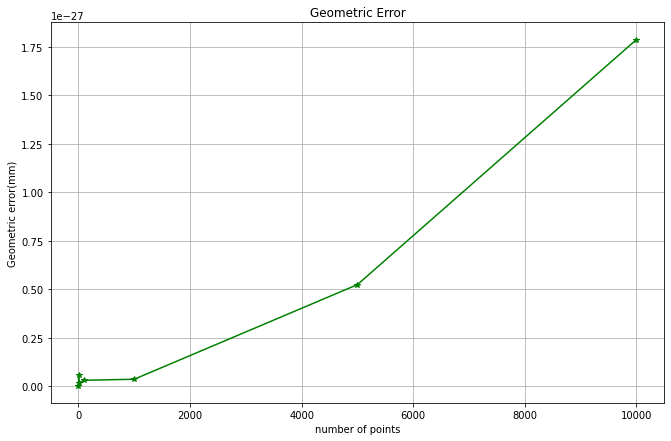

In [16]:
fig= plt.figure(figsize=(11,7))
ax = fig.add_subplot()

ax.plot(n_pts,err_list,'g*-')
ax.grid()
ax.set_title("Geometric Error")
ax.set_xlabel("number of points")
ax.set_ylabel("Geometric error(mm)")
plt.show()